In [1]:
!pip install -q kagglehub

In [2]:
import kagglehub

path = kagglehub.dataset_download("soumyakushwaha/indian-sign-language-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'indian-sign-language-dataset' dataset.
Path to dataset files: /kaggle/input/indian-sign-language-dataset


In [3]:
!ls $path*

ISL_Dataset


In [4]:
!ls $path/ISL_Dataset*

A  B  C  D  E  F  G  I	K  L  M  N  O  P  Q  R	S  T  U  V  W  X  Z


In [5]:
DATASET_PATH = path + "/ISL_Dataset"
IMG_SIZE = 64

In [7]:
import os
import cv2
import numpy as np

images = []
labels = []

for label in os.listdir(DATASET_PATH):
  label_path = os.path.join(DATASET_PATH, label)
  if not os.path.isdir(label_path):
    continue
  for image_name in os.listdir(label_path):
    img_path = os.path.join(label_path, image_name)
    image = cv2.imread(img_path)
    if image is None:
      continue
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    images.append(gray)
    labels.append(label)
images = np.array(images)
labels = np.array(labels)

print("Total samples:", len(images))

Total samples: 702


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_train, X_test, y_train, y_test = train_test_split(
    images,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print(X_train.shape, X_test.shape)


(561, 64, 64) (141, 64, 64)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_train, X_test, y_train, y_test = train_test_split(
    images,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print(X_train.shape, X_test.shape)


(561, 64, 64) (141, 64, 64)


In [12]:
from skimage.feature import hog
import numpy as np

def extract_hog_batch(images):
    features = []
    for img in images:
        feat = hog(
            img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm="L2-Hys"
        )
        features.append(feat)
    return np.array(features)

X_train_hog = extract_hog_batch(X_train)
X_test_hog = extract_hog_batch(X_test)

print(X_train_hog.shape)


(561, 1764)


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_hog = scaler.fit_transform(X_train_hog)
X_test_hog = scaler.transform(X_test_hog)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

lr.fit(X_train_hog, y_train_enc)
y_pred_lr = lr.predict(X_test_hog)

print("Logistic Regression Accuracy:",
      accuracy_score(y_test_enc, y_pred_lr))


Logistic Regression Accuracy: 0.6099290780141844


In [15]:
from sklearn.linear_model import SGDClassifier

svm = SGDClassifier(
    loss="hinge",
    max_iter=1000,
    tol=1e-3,
    random_state=42
)

svm.fit(X_train_hog, y_train_enc)
y_pred_svm = svm.predict(X_test_hog)

print("Linear SVM (SGD) Accuracy:",
      accuracy_score(y_test_enc, y_pred_svm))


Linear SVM (SGD) Accuracy: 0.5035460992907801


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_hog, y_train_enc)

y_pred_rf = rf.predict(X_test_hog)

print("Random Forest Accuracy:",
      accuracy_score(y_test_enc, y_pred_rf))


Random Forest Accuracy: 0.5602836879432624


In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

BATCH_SIZE = 32
DATA_DIR = path + "/ISL_Dataset"

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

print("Classes:", class_names)
print("Number of classes:", NUM_CLASSES)

Found 702 files belonging to 23 classes.
Using 562 files for training.
Found 702 files belonging to 23 classes.
Using 140 files for validation.
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Z']
Number of classes: 23


In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE = 64
NUM_CLASSES = len(train_ds.class_names)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
])

model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Rescaling(1./255),
    data_augmentation,

    layers.Conv2D(16, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12
)

val_loss, val_acc = model.evaluate(val_ds)
print("CNN Validation Accuracy:", val_acc)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 23)             │         1,495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 408,055 (1.56 MB)

 Trainable params: 408,055 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.0598 - loss: 3.1565 - val_accuracy: 0.0500 - val_loss: 3.1338
Epoch 2/12
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.0540 - loss: 3.1222 - val_accuracy: 0.0643 - val_loss: 3.1346
Epoch 3/12
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.0594 - loss: 3.1234 - val_accuracy: 0.0571 - val_loss: 3.1376
Epoch 4/12
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.0684 - loss: 3.1049 - val_accuracy: 0.0571 - val_loss: 3.1424
Epoch 5/12
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.0612 - loss: 3.0691 - val_accuracy: 0.0714 - val_loss: 3.1163
Epoch 6/12
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.0849 - loss: 3.0353 - val_accuracy: 0.0571 - val_loss: 3.1454
Epoch 7/12
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.1066 - loss: 3.0016 - val_accuracy: 0.0714 - val_loss: 3.1159
Epoch 8/12
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.1272 - loss: 2.9269 - val_accuracy: 0.

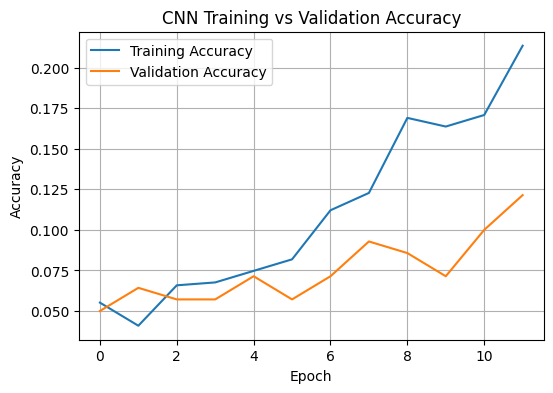

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

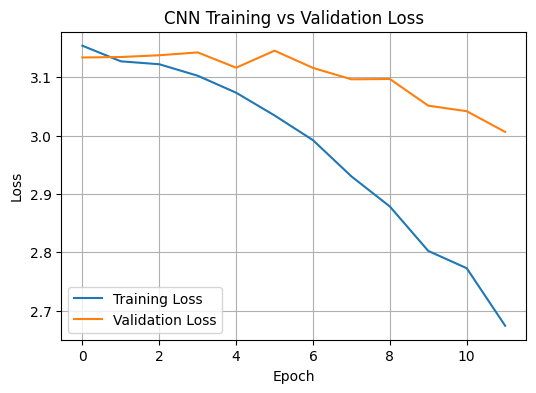

In [28]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


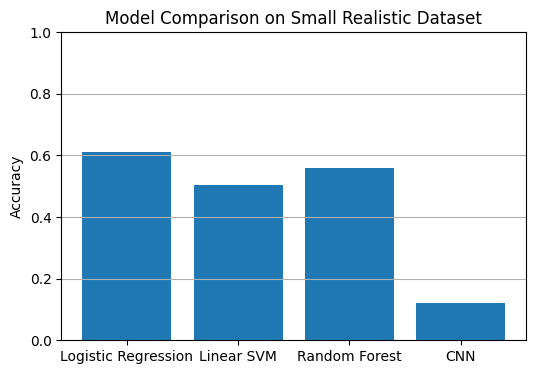

In [29]:
models = ['Logistic Regression', 'Linear SVM', 'Random Forest', 'CNN']
accuracies = [accuracy_score(y_test_enc, y_pred_lr), accuracy_score(y_test_enc, y_pred_svm), accuracy_score(y_test_enc, y_pred_rf), val_acc]

plt.figure(figsize=(6,4))
plt.bar(models, accuracies)
plt.ylabel('Accuracy')
plt.title('Model Comparison on Small Realistic Dataset')
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()


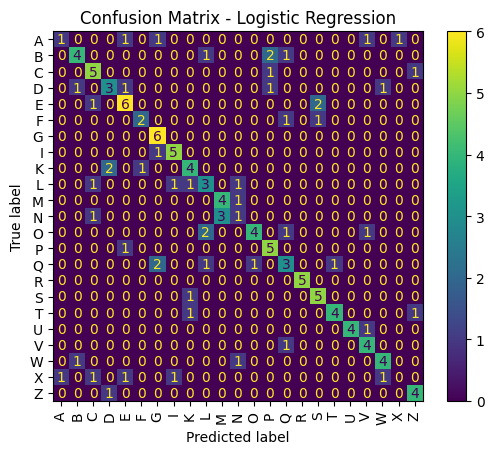

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_enc, y_pred_lr)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp.plot(xticks_rotation=90)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()
